# Index

1. [Imports](#Imports)
2. [ResNet 50](#ResNet-50)
    - [Optuna Optimization](#Optuna-optimization)
    - [Optuna Optimization - Intensive search for the best optimizer](#Intensive-search-for-the-Best-Optimizer)
3. [Train ResNet50 (best hyperparameters)](#Train-ResNet50-with-the-hyperparameters-found)

# Imports

In [12]:
# Add project src folder to PYTHONPATH
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

src_path = os.path.join(project_root, "src")
sys.path.append(src_path)

# Standard Libraries
import json
import glob
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

# yTorch & Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

# sklearn metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

from tqdm import tqdm

# Reproducibility
from optimization.utils.reproducibility import set_seed, seed_worker

# Data Loading
from optimization.loaders.data_loader import LungCancerDataset, create_dataloader

# Objective Functions
from optimization.objectives.objective_generic import objective_generic
from optimization.objectives.objective_sgd import objective_sgd
from optimization.objectives.objective_sgd_steplr import objective_sgd_steplr
from optimization.objectives.objective_sgd_steplr_intensive_search import (
    objective_sgd_steplr_intensive_search
)

# Optuna training orchestrator
from modeling.resnet50.train_resnet50 import train_ResNet50_optuna_hyperparams

# Evaluation script
from modeling.resnet50.eval_resnet50 import evaluate_resnet50

## Seting seed (for reproducibility)

In [2]:
set_seed(42)

# Dataset (ResNet50)

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),  # Convert to tensor (scaling to 0-1 already done by division by 255)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet's scale
])

# File Paths
train_files = os.path.join(project_root, '/data/yolo/LUNG_PET_CT/patient_split_augmented/train')
val_files = os.path.join(project_root, '/data/yolo/LUNG_PET_CT/patient_split_augmented/val')

# Dataset and DataLoader
train_dataset = LungCancerDataset(train_files, transform=transform)
val_dataset = LungCancerDataset(val_files, transform=transform)

# Optuna optimization 

In [ ]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [ ]:
optuna_results_dir = os.path.join(project_root, '/src/optimization/optuna_results')

Optuna to search for the best hyperparameters for ResNet-50

## Optuna - Search for best optimizer (Adam, SGD, RMSprop)

In [4]:
# Directory to store results
RESULTS_DIR = os.path.join(project_root, '/src/optimization/optuna_results/trial_results')
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42) 
)

study.optimize(objective,
               n_trials=50,
               n_jobs=1,
               gc_after_trial=True,
               callbacks=[progress_callback]
              )

#### Save Results

In [ ]:
# Save best hyperparameters
best_params_path_objective_generic= os.path.join(optuna_results_dir, "best_hyperparameters_objective_generic.json")
with open(best_params_path_objective_generic, "w") as f:
    json.dump(study.best_params, f, indent=4)

print(f"Best hyperparameters for ResNet50: {best_params_path_objective_generic}")

In [39]:
print(study.best_value)

0.39654512852208934


#### Load Results

In [7]:
with open(best_params_path_objective_generic, "r") as f:
    best_params_path_objective_generic = json.load(f)

print("Loaded Hyperparameters:", best_params_path_objective_generic)

Loaded Hyperparameters: {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}


## Optuna - Search for SGD optimizer

In [34]:
# Directory to store results
RESULTS_DIR = os.path.join(project_root, '/src/optimization/optuna_results/trial_results_SGD"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
study_SGD = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
)
study_SGD.optimize(objective_sgd,
                   n_trials=50,
                   n_jobs=1,
                   gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

#### Save Results

In [ ]:
# Save best hyperparameters
best_params_path_SGD = os.path.join(optuna_results_dir, "best_hyperparameters_SGD.json")
with open(best_params_path_SGD, "w") as f:
    json.dump(study_SGD.best_params, f, indent=4)

print(f"Best hyperparameters for ResNet50: {best_params_path_SGD}")

In [40]:
print(study_SGD.best_value)

0.39430431372284513


0.39430431372284513

#### Load Results

In [38]:
with open(best_params_path_SGD, "r") as f:
    best_params_SGD = json.load(f)

print("Loaded Hyperparameters:", best_params_SGD)

Loaded Hyperparameters: {'learning_rate': 4.8733423774825025e-06, 'batch_size': 16, 'weight_decay': 0.004493403189321242, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.04811257676075818, 'momentum': 0.9433103253272241, 'step_size': 5, 'gamma': 0.5417209163329839}


## Optuna - Search for SGD optimizer + StepLR

| **Parameter**       | **Higher Value Effect**                            | **Lower Value Effect**                           | **Common Practical Range** |
|--------------------|---------------------------------------------------|------------------------------------------------|-----------------------------|
| **Momentum**        | Faster convergence, but risk of overshooting     | Slower convergence, more stable                | 0.85 - 0.95                 |
| **Step Size**       | Slower decay, longer exploration                 | Faster decay, quicker convergence              | 3 - 10 epochs               |
| **Gamma**           | Gradual LR decay, stable learning                | Faster decay, risk of premature convergence    | 0.5 - 0.9                   |
| **Label Smoothing** | Better generalization, less overfitting          | More confidence, risk of overfitting           | 0.05 - 0.2                  |


In [58]:
# Directory to store results
RESULTS_DIR = os.path.join(project_root, '/src/optimization/optuna_results/trial_results_SGD_StepLR"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
study_SGD_StepLR = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
)
study_SGD_StepLR.optimize(objective,
                          n_trials=70,
                          n_jobs=1,
                          gc_after_trial=True,
                          callbacks=[progress_callback]
                         )

#### Save Results

In [ ]:
best_params_path_SGD_StepLR = os.path.join(optuna_results_dir, "best_hyperparameters_SGD_StepLR.json")
with open(best_params_path_SGD_StepLR, "w") as f:
    json.dump(study_SGD_StepLR.best_params, f, indent=4)

print(f"Best hyperparameters for ResNet50: {best_params_path_SGD_StepLR}")

In [61]:
print(study_SGD_StepLR.best_value)

0.399760811078408


0.399760811078408

#### Load Results

In [10]:
with open(best_params_path_SGD_StepLR, "r") as f:
    best_params_path_SGD_StepLR = json.load(f)

print("Loaded Hyperparameters:", best_params_path_SGD_StepLR)

Loaded Hyperparameters: {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}


## Optuna - Search for SGD optimizer + StepLR (Intensive search)

In [58]:
# Directory to store results
RESULTS_DIR = os.path.join(project_root, '/src/optimization/optuna_results/trial_results_SGD_StepLR_50epochs_2"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
study_SGD_StepLR_50_2 = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42) 
)
study_SGD_StepLR_50_2.optimize(objective,
                               n_trials=30, n_jobs=1,
                               gc_after_trial=True,
                               callbacks=[progress_callback]
                              )

#### Save Results

In [ ]:
# Save best hyperparameters
best_params_path_SGD_StepLR_50_2 = os.path.join(optuna_results_dir, "best_hyperparameters_SGD_StepLR_50epochs_2.json")
with open(best_params_path_SGD_StepLR_50_2, "w") as f:
    json.dump(study_SGD_StepLR_50_2.best_params, f, indent=4)

print(f"Best hyperparameters for ResNet50: {best_params_path_SGD_StepLR_50_2}")

In [9]:
print(study_SGD_StepLR_50_2.best_value)

0.4212451693489931


#### Load Results

In [10]:
with open(best_params_path_SGD_StepLR_50_2, "r") as f:
    best_params_path_SGD_StepLR_50_2 = json.load(f)

print("Loaded Hyperparameters:", best_params_path_SGD_StepLR_50_2)

Loaded Hyperparameters: {'learning_rate': 1.035046459447574e-06, 'batch_size': 32, 'weight_decay': 0.0006775499840802566, 'trainable_layers': 4, 'dropout_rate': 0.20144072044874892, 'label_smoothing': 0.07199073214843173, 'momentum': 0.9474227002735129, 'step_size': 16, 'gamma': 0.5763511540167814}


# Train ResNet50 with the hyperparameters found

## Trial trial_results_SGD_StepLR_50epochs -> Trial 3

In [ ]:
# Get the best parameters
path_1 = os.path.join(optuna_results_dir, "/trial_results_SGD_StepLR_50epochs/trial_3_GOOD.json")
with open(path_1, "r") as f:
    best_params_1 = json.load(f)
    
best_params_1 = best_params_1['hyperparameters']

best_params_1['momentum'] = best_params_1['optimizer']['parameters']['momentum']
best_params_1['gamma'] = best_params_1['scheduler']['parameters']['gamma']
best_params_1['step_size'] = best_params_1['scheduler']['parameters']['step_size']

best_params_1['optimizer'] = {'type': best_params_1['optimizer']}
best_params_1['scheduler'] = {'type': best_params_1['scheduler']}


# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_1.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_history_1.csv")
model_save_path = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_1.pth")

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_1, train_dataset, val_dataset)

## Trial trial_results_SGD_StepLR_50epochs_2 -> Trial 5

In [ ]:
# Get the best parameters
path_2 = os.path.join(optuna_results_dir, "/trial_results_SGD_StepLR_50epochs_2/trial_5_GOOD.json")
with open(path_2, "r") as f:
    best_params_2 = json.load(f)
    

best_params_2 = best_params_2['hyperparameters']

best_params_2['momentum'] = best_params_2['optimizer']['parameters']['momentum']
best_params_2['gamma'] = best_params_2['scheduler']['parameters']['gamma']
best_params_2['step_size'] = best_params_2['scheduler']['parameters']['step_size']

best_params_2['optimizer'] = {'type': best_params_2['optimizer']}
best_params_2['scheduler'] = {'type': best_params_2['scheduler']}

# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_2.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_history_2.csv")
model_save_path = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_2.pth")


# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_2, train_dataset, val_dataset)

## Trial trial_results_SGD_StepLR_50epochs_2 -> Trial 27

In [ ]:
# Get the best parameters
path_3 = os.path.join(optuna_results_dir, "/trial_results_SGD_StepLR_50epochs_2/trial_27_GOOD.json")
with open(path_3, "r") as f:
    best_params_4 = json.load(f)
    
best_params_4 = best_params_4['hyperparameters']

best_params_4['momentum'] = best_params_4['optimizer']['parameters']['momentum']
best_params_4['gamma'] = best_params_4['scheduler']['parameters']['gamma']
best_params_4['step_size'] = best_params_4['scheduler']['parameters']['step_size']

best_params_4['optimizer'] = {'type': best_params_4['optimizer']}
best_params_4['scheduler'] = {'type': best_params_4['scheduler']}

# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_4.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_history_4.csv")
model_save_path = os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_4.pth")

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_4, train_dataset, val_dataset)

# Evaluate ResNet50 - Test set

In [17]:
evaluate_resnet50(
    checkpoint_path= os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_1.pth",
    test_data_path= os.path.join(project_root, "/data/yolo/LUNG_PET_CT/patient_split/test/images)",
    save_path= "test_metrics_model_1_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 43/43 [00:26<00:00,  1.63batch/s]


Test Loss: 1.2777
Test Accuracy: 0.4219
Test Precision: 0.4154
Test Recall: 0.4219
Test F1-Score: 0.4166

Classification Report:

              precision    recall  f1-score   support

           A       0.48      0.50      0.49       475
           B       0.33      0.25      0.28       354
           E       0.36      0.40      0.38        43
           G       0.42      0.48      0.45       486

    accuracy                           0.42      1358
   macro avg       0.40      0.40      0.40      1358
weighted avg       0.42      0.42      0.42      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_1_weighted.csv

Confusion Matrix:

[[237  75  22 141]
 [ 87  88   6 173]
 [ 20   4  17   2]
 [150 103   2 231]]


In [25]:
evaluate_resnet50(
    checkpoint_path= os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_2.pth",
    test_data_path= os.path.join(project_root, "/data/yolo/LUNG_PET_CT/patient_split/test/images)",
    save_path= "test_metrics_model_2_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 85/85 [00:26<00:00,  3.17batch/s]


Test Loss: 1.2797
Test Accuracy: 0.4116
Test Precision: 0.4085
Test Recall: 0.4116
Test F1-Score: 0.4048

Classification Report:

              precision    recall  f1-score   support

           A       0.51      0.48      0.50       475
           B       0.30      0.20      0.24       354
           E       0.29      0.47      0.35        43
           G       0.39      0.49      0.44       486

    accuracy                           0.41      1358
   macro avg       0.37      0.41      0.38      1358
weighted avg       0.41      0.41      0.40      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_2_.csv


In [8]:
evaluate_resnet50(
    checkpoint_path= os.path.join(src_path, "/training/ResNet50/final_training/ResNet50_final_model_4.pth",
    test_data_path= os.path.join(project_root, "/data/yolo/LUNG_PET_CT/patient_split/test/images)",
    save_path= "test_metrics_model_4_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 43/43 [00:20<00:00,  2.10batch/s]


Test Loss: 1.2239
Test Accuracy: 0.4286
Test Precision: 0.4226
Test Recall: 0.4286
Test F1-Score: 0.4199

Classification Report:

              precision    recall  f1-score   support

           A       0.51      0.51      0.51       475
           B       0.34      0.26      0.30       354
           E       0.30      0.07      0.11        43
           G       0.40      0.50      0.45       486

    accuracy                           0.43      1358
   macro avg       0.39      0.34      0.34      1358
weighted avg       0.42      0.43      0.42      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_4_weighted.csv


In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import glob
from tqdm import tqdm
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load trained ResNet-50 model
def load_resnet50_feature_extractor(checkpoint_path):
    device = torch.device("mps")

    # Load ResNet-50 model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    
    # Remove last fully connected layer (keep feature extractor)
    model = nn.Sequential(*list(model.children())[:-1])
    model = model.to(device)
    model.eval()

    # Load trained weights
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=False)

    print("ResNet-50 model loaded as a feature extractor.")
    return model, device

# Dataset class
class LungCancerDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.class_map = {'A': 0, 'B': 1, 'E': 2, 'G': 3}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.class_map[os.path.basename(file_path)[0]]  # Extract label from filename
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Extract feature embeddings from ResNet-50
def extract_features(model, dataloader, device):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting Features", unit="batch"):
            images = images.to(device)

            # Forward pass to extract features
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten feature maps

            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    return np.vstack(features), np.hstack(labels)

# Train SVM classifier on **train features only**
def train_svm_classifier(train_features, train_labels):
    print("\nTraining SVM on ResNet-50 features...")
    
    # Normalize features
    svm_model = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
    
    # Train SVM on train features only
    svm_model.fit(train_features, train_labels)

    print("SVM training complete.")
    return svm_model

# Evaluate the SVM classifier on test features
def evaluate_svm(svm_model, test_features, test_labels, class_names):
    print("\nEvaluating SVM model...")

    # Predict test labels
    test_preds = svm_model.predict(test_features)

    # Compute accuracy
    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(test_labels, test_preds, target_names=class_names))

    # Print confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("\nConfusion Matrix:\n", cm)

    return accuracy, cm

# Paths
checkpoint_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth"
train_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/train/images"
test_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split patient 4/test/images"
val_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/val/images"

# Define transformations (ResNet-50 requires 224x224 input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_files = glob.glob(os.path.join(train_data_path, "*"))
test_files = glob.glob(os.path.join(test_data_path, "*"))
val_files = glob.glob(os.path.join(val_data_path, "*"))

train_dataset = LungCancerDataset(train_files, transform=transform)
test_dataset = LungCancerDataset(test_files, transform=transform)
val_dataset = LungCancerDataset(val_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Load ResNet-50 as feature extractor
resnet_model, device = load_resnet50_feature_extractor(checkpoint_path)

# Extract features **separately** for train and test sets
train_features, train_labels = extract_features(resnet_model, train_loader, device)
test_features, test_labels = extract_features(resnet_model, test_loader, device)
val_features, val_labels = extract_features(resnet_model, val_loader, device)

ResNet-50 model loaded as a feature extractor.


Extracting Features: 100%|███████████████████| 64/64 [00:43<00:00,  1.47batch/s]


In [ ]:
# Train SVM on **train features only**
svm_model = train_svm_classifier(train_features, train_labels)

# Evaluate SVM on **test features**
class_names = list(test_dataset.class_map.keys())
evaluate_svm(svm_model, test_features, test_labels, class_names)


Test Accuracy (SVM on ResNet Features): 0.4278

Classification Report (SVM on ResNet Features):

              precision    recall  f1-score   support

           A       0.53      0.44      0.48       475
           B       0.35      0.36      0.35       354
           E       0.00      0.00      0.00        43
           G       0.41      0.50      0.45       486

    accuracy                           0.43      1358
   macro avg       0.32      0.33      0.32      1358
weighted avg       0.42      0.43      0.42      1358


Confusion Matrix (SVM on ResNet Features):
 [[210  46   2 217]
 [ 97 126   0 131]
 [ 24  13   0   6]
 [ 67 174   0 245]]


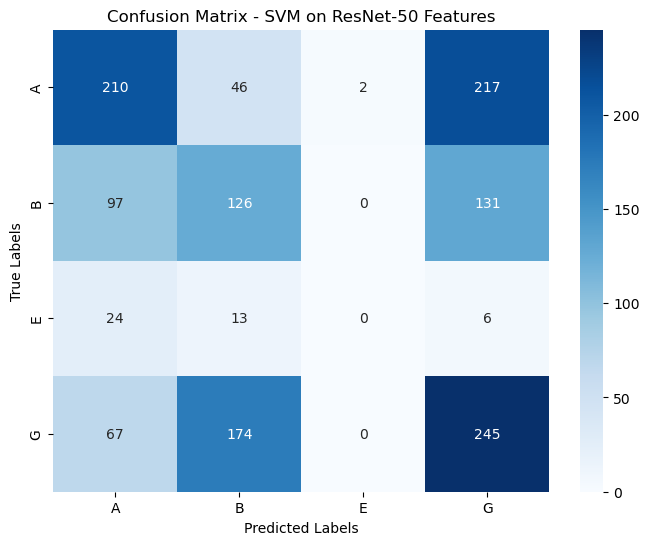

In [42]:
# Predict using SVM
svm_preds = svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np
from itertools import product  # For looping through hyperparameters
from tqdm import tqdm  # Progress bar

# Define hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization strength
    "kernel": ["sigmoid"],  # Different kernels
    "gamma": [0.01, 0.1, 1]  # RBF/Sigmoid/Poly kernel gamma
}

# Store best parameters and best F1-score
best_f1 = 0
best_params = None

# Get all possible parameter combinations
param_combinations = list(product(param_grid["C"], param_grid["kernel"], param_grid["gamma"]))

# Initialize progress bar
with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning", unit="trial") as pbar:
    for C, kernel, gamma in param_combinations:
        if kernel == "linear" and gamma != "scale":
            pbar.update(1)
            continue  # gamma is not used for linear kernel
        
        # Create SVM model pipeline
        svm_model = make_pipeline(StandardScaler(), SVC(C=C, kernel=kernel, gamma=gamma))

        # Train on training set
        svm_model.fit(train_features, train_labels)

        # Predict on testidation set
        test_preds = svm_model.predict(test_features)

        # Compute F1-score on testidation set
        test_f1 = f1_score(test_labels, test_preds, average="weighted")

        # Print progress
        tqdm.write(f"Testing C={C}, Kernel={kernel}, Gamma={gamma} -> testidation F1 Score: {test_f1:.4f}")

        # Update best parameters if current F1-score is better
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_params = {"C": C, "kernel": kernel, "gamma": gamma}

        # Update progress bar
        pbar.update(1)

# Print best hyperparameters based on testidation set
print("\nBest SVM Hyperparameters:")
print(best_params)
print(f"Best Weighted F1 Score on test: {best_f1:.4f}")

Hyperparameter Tuning:   0%|                          | 0/12 [00:00<?, ?trial/s]

In [44]:
# Train final SVM model with best hyperparameters
best_svm_model = make_pipeline(StandardScaler(), SVC(**best_params))
best_svm_model.fit(train_features, train_labels)

# Return best parameters
best_params

{'C': 0.1, 'kernel': 'sigmoid', 'gamma': 1}

Test Accuracy (SVM on ResNet Features): 0.2865

Classification Report (SVM on ResNet Features):

              precision    recall  f1-score   support

           A       0.38      0.32      0.34       475
           B       0.23      0.17      0.20       354
           E       0.09      0.67      0.16        43
           G       0.39      0.31      0.34       486

    accuracy                           0.29      1358
   macro avg       0.27      0.37      0.26      1358
weighted avg       0.33      0.29      0.30      1358


Confusion Matrix (SVM on ResNet Features):
 [[150 107 109 109]
 [ 51  61 118 124]
 [ 11   0  29   3]
 [185  96  56 149]]


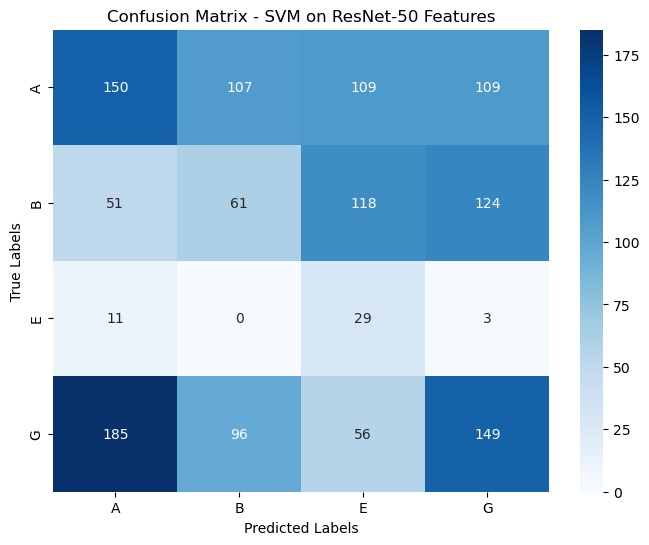

In [45]:
# Predict using SVM
svm_preds = best_svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()

In [ ]:
# Predict using SVM
best_svm_model = make_pipeline(StandardScaler(), SVC(kernel="sigmoid", C=1, gamma=1))
best_svm_model.fit(train_features, train_labels)
svm_preds = best_svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()